In [1]:
%matplotlib inline
import random
from PIL import Image
import imagehash
import pandas as pd
import os 
from tqdm import tqdm, tqdm_notebook
from commons.config import CIMRI_CSV, IMAGE_DOWNLOAD_PATH
import glob
from functools import reduce #python 3


2019-06-19 12:42:41,861 : INFO : Checking directories...
2019-06-19 12:42:41,862 : INFO : Directories are set.


In [2]:
df = pd.read_csv(CIMRI_CSV)

In [3]:
df.count()

Unnamed: 0           786103
firstProduct         786103
secondProduct        786103
isSame               786103
categoryIdOfFirst    786103
productId            786103
offerId              786103
productImages        786103
offerImages          786103
dtype: int64

In [4]:
len(df.loc[df.isSame == 0])

45184

In [5]:
df_negatives = df.loc[df.isSame == 0]

In [6]:
images_list = glob.glob("{0}*.jpg".format(IMAGE_DOWNLOAD_PATH))
images_list = [int(x.split('/')[-1].replace('.jpg', '')) for x in images_list]

In [7]:
images_list = set(images_list)
len(images_list)

993244

In [8]:
next(iter(images_list))

90177536

In [9]:
def does_image_exists(img_id):
    return int(img_id) in images_list

In [10]:
def available_image_count(row):
    product = len([x for x in row['productImages'].split('-') if does_image_exists(x)])
    offer = len([x for x in row['offerImages'].split('-') if does_image_exists(x)])
    return product + offer

In [11]:
tqdm.pandas(desc = 'Counting available images.')
df_negatives['image_count'] = df_negatives.progress_apply(lambda row: available_image_count(row), axis =1 ) 

Counting available images.: 100%|██████████| 45184/45184 [00:01<00:00, 43286.02it/s]
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


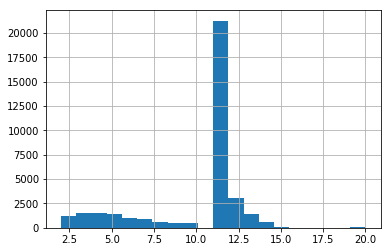

In [12]:
df_negatives.loc[df_negatives.image_count >= 2].image_count.hist(bins=20)

In [13]:
df_negatives.loc[df_negatives.image_count >= 2].count()

Unnamed: 0           35568
firstProduct         35568
secondProduct        35568
isSame               35568
categoryIdOfFirst    35568
productId            35568
offerId              35568
productImages        35568
offerImages          35568
image_count          35568
dtype: int64

In [14]:
tqdm.pandas(desc = 'Counting available images.')
df['image_count'] = df.progress_apply(lambda row: available_image_count(row), axis = 1) 

Counting available images.: 100%|██████████| 786103/786103 [00:17<00:00, 44825.14it/s]


In [15]:
df = df.loc[df.image_count >= 4]

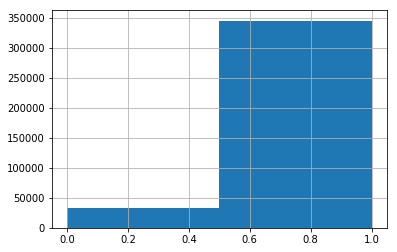

In [16]:
df.isSame.hist(bins=2)

In [17]:
product_ids = df.productId.unique().tolist()

In [18]:
len(product_ids)

184315

In [19]:
def find_duplicate_images(images):
    img_to_delete = []
    hashes = []
    for img in images:
        h = imagehash.average_hash(Image.open(IMAGE_DOWNLOAD_PATH + img + '.jpg'))
        if h in hashes:
            img_to_delete.append(img)
        else:
            hashes.append(h)
    return img_to_delete

In [20]:
data_set = []
for product_id in tqdm_notebook(product_ids[:50], desc = 'Generating image triplets'):
    try:
         # Find images
        original = df.loc[df.productId == product_id].head().productImages.tolist()
        neg = df.loc[df.productId == product_id].loc[df.isSame == 0].offerImages.tolist()
        pos = df.loc[df.productId == product_id].loc[df.isSame == 1].offerImages.tolist()

        # Parse image columns
        original = [imgs.split('-') for imgs in original]
        neg = [imgs.split('-') for imgs in neg]
        pos = [imgs.split('-') for imgs in pos]

        if len(original) == 0 or len(neg) == 0 or len(pos) == 0:
            continue

        # Omit duplicate ids
        original = list(set(reduce(lambda x,y: x + y, original)))
        neg = list(set(reduce(lambda x,y: x + y, neg)))
        pos = list(set(reduce(lambda x,y: x + y, pos)))

        # Leave only available images
        original = [img for img in original if does_image_exists(img)]
        neg = [img for img in neg if does_image_exists(img)]
        pos = [img for img in pos if does_image_exists(img)]

        # Delete duplicate images
        images_to_del = find_duplicate_images(neg + pos + original)

        original = [img for img in original if img not in images_to_del]
        pos = [img for img in pos if img not in images_to_del]
        neg = [img for img in neg if img not in images_to_del]

        # Create triplets
        if len(neg) > 0 and len(pos) > 0 and len(original) > 0:
            min_size = min(len(neg), len(pos), len(original))
            pos = random.sample(pos, min_size)
            neg = random.sample(neg, min_size)
            original = random.sample(original, min_size)
            for p, n, o in zip(pos, neg, original):
                data_set.append([o, p, n])
    except Exception as exp:
        print(exp)

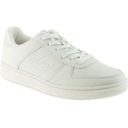

original


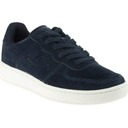

positive


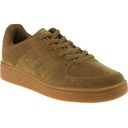

anchor


In [27]:
from IPython.core.display import Image, display
for name, img in zip(['original', 'positive', 'anchor'], random.sample(data_set, 1)[0]):
    url = "https://cdn.cimri.io/image/{0}x{0}/asdf_{1}.jpg".format(128, img)
    display(Image(url, unconfined=True))
    print(name)